# IMPORT NECESSARY LIBRARIES

In [1]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

In [2]:
import numpy as np
import cv2 as cv
import random
import os
import matplotlib.pyplot as plt
import pickle
import keras
import tensorflow as tf
%matplotlib inline

# EXTRACT HEIGHT AND WEIGHT FROM DATASET

In [3]:
processed_images_input=[]
hw_target=[]
folder_path="image"

In [4]:
for file_name in os.listdir(folder_path):
    if file_name.endswith('.jpg'):
      image_path = os.path.join(folder_path, file_name)
      img = cv.imread(image_path)
      img = cv.resize(img, (224, 224))
      processed_images_input.append(img)
      try:
        weight_target = int(file_name.split('_')[2])
        height_target = int(file_name.split('_')[3])
        hw_target.append([height_target,weight_target])
      except:
        pass


# CALCULATE BMI USING FORMULA

In [7]:
# Function to calculate BMI
bmi_target=[]
def calculate_bmi(height, weight):

    # Calculate BMI using the formula: BMI = weight (kg) * 703 / (height (m))^2
    BMI = weight *703 / (height ** 2)

    return BMI

# Calculate BMI for each entry in labels and append it to a new list
bmi_target_1 = [calculate_bmi(height_target, weight_target) for height_target, weight_target in hw_target]

# Append BMI values to the existing labels list
for i in range(len(hw_target)):
    bmi_target.append(bmi_target_1[i])

In [6]:
len(bmi_target)

5898

In [8]:
len(processed_images_input)

5900

In [9]:
bmi_target[0]

36.01915794163511

# CREATE A TRAINABLE BASE MODEL RESNET152

In [10]:
input_shape=(224,224,3)
base_model_1=keras.applications.ResNet152(include_top=False,
                                       weights='imagenet',
                                       input_shape=input_shape,
                                       pooling='avg')
base_model_1.trainable=False
base_model_1.summary()

Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

# CREATE A TRAINING AND TESTING SET

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
print(len(processed_images_input))
print(len(bmi_target))
min_len = min(len(processed_images_input), len(bmi_target))
processed_images_input = processed_images_input[:min_len]
bmi_target = bmi_target[:min_len]
X_train,X_test,Y_train,Y_test=train_test_split(processed_images_input,bmi_target,test_size=0.2,random_state=42)

5900
5898


In [13]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing import image

In [14]:
processed_images_input[0].shape

(224, 224, 3)

# BUILD A SEQUENTIAL MODEL AND ADD THE FULLY CONNECTED LAYERS WITH RELU AS ACTIVATION, ADAM OPTIMIZER AND MAE LOSS

In [15]:
bmi_model=Sequential()
bmi_model.add(base_model_1)
bmi_model.add(layers.Dense(256, activation='relu',input_dim=2048))
bmi_model.add(layers.Dropout(0.25))
bmi_model.add(layers.Dense(1, activation='linear'))

C:\Users\binoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
optimizer = optimizers.Adam(learning_rate=0.001)  # Adjust learning rate as needed
bmi_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [17]:
X_train=np.array(X_train, dtype=np.float32)
X_test=np.array(X_test, dtype=np.float32)
Y_train=np.array(Y_train, dtype=np.float32)
Y_test=np.array(Y_test, dtype=np.float32)

# FIT THE MODEL WITH 25 EPOCHS AND BATCH SIZE 32

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define an early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = bmi_model.fit(
    X_train, Y_train, 
    epochs=50,  # Increased epochs to 50 for better learning
    validation_data=(X_test, Y_test),
    verbose=2, 
    batch_size=16,  # Try a smaller batch size for better generalization
    callbacks=[early_stopping]  # Add early stopping to prevent overfitting
)


Epoch 1/50
295/295 - 462s - 2s/step - loss: 84.8427 - mae: 6.8793 - val_loss: 69.8573 - val_mae: 6.0309
Epoch 2/50
295/295 - 610s - 2s/step - loss: 67.7515 - mae: 6.1626 - val_loss: 68.7401 - val_mae: 6.1161
Epoch 3/50
295/295 - 475s - 2s/step - loss: 65.8490 - mae: 6.1027 - val_loss: 70.2481 - val_mae: 6.3835
Epoch 4/50
295/295 - 418s - 1s/step - loss: 62.0033 - mae: 5.9067 - val_loss: 70.4280 - val_mae: 5.9647
Epoch 5/50
295/295 - 491s - 2s/step - loss: 58.4645 - mae: 5.7331 - val_loss: 68.0575 - val_mae: 5.9234
Epoch 6/50
295/295 - 508s - 2s/step - loss: 55.9680 - mae: 5.6446 - val_loss: 70.9351 - val_mae: 5.9675
Epoch 7/50
295/295 - 442s - 1s/step - loss: 55.6106 - mae: 5.6032 - val_loss: 68.7592 - val_mae: 5.9606
Epoch 8/50
295/295 - 377s - 1s/step - loss: 53.3236 - mae: 5.4829 - val_loss: 72.9532 - val_mae: 6.5773
Epoch 9/50
295/295 - 372s - 1s/step - loss: 52.1932 - mae: 5.4545 - val_loss: 77.4367 - val_mae: 6.1897
Epoch 10/50
295/295 - 374s - 1s/step - loss: 50.8745 - mae: 5.40

In [20]:
bmi_model.save('my_model1.h5')

KeyboardInterrupt: 

# EVALUATE THE MODEL

In [21]:
validation_loss=[]
results=bmi_model.evaluate(X_test, Y_test)
validation_loss.append(results)

37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 59.8479 - mae: 5.6365


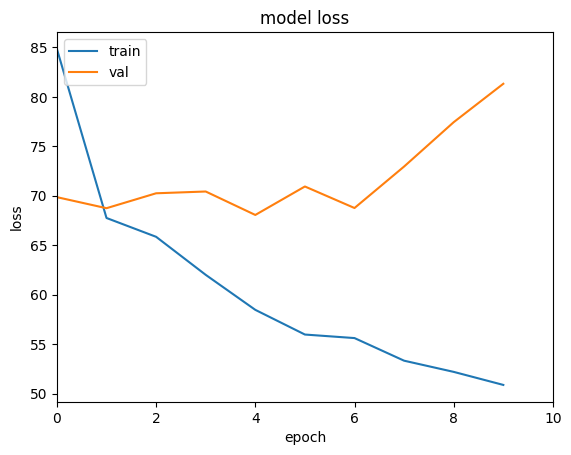

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
axes = plt.gca()
axes.set_xlim([0, 10])
plt.show()


### The graph shows that the model does not overfit

# TEST WITH PHOTO!
### Use human parsing/masking of images as preprocessing

In [23]:
import cv2 as cv
import torch
from torchvision import transforms
from PIL import Image
import tensorflow

Using cache found in C:\Users\binoj/.cache\torch\hub\pytorch_vision_v0.10.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


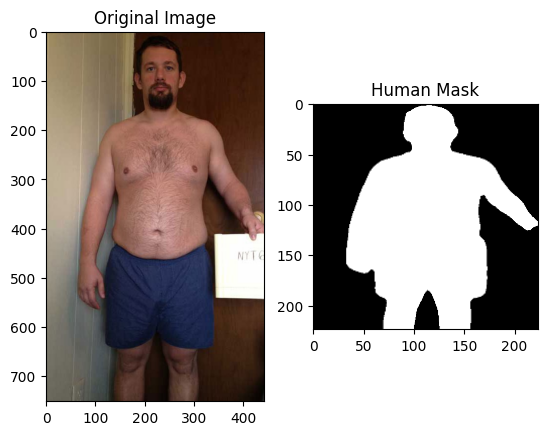

BMI: 14.055388450622559
Underweight


In [29]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

def generate_human_mask(image_path):
    # Load pre-trained DeepLabV3 model from PyTorch
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    # Define transformations
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image using PIL (Python Imaging Library)
    img = Image.open(image_path)

    # Preprocess the image
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        output = model(input_batch)["out"][0]
    output_predictions = output.argmax(0)

    # Create a binary mask for the human class (label 15)
    human_mask = (output_predictions == 15).float().numpy()

    return human_mask

# Load the Keras model
model = tf.keras.models.load_model('my_model1.keras')

# Load the image path and generate the human mask
image_path = 'image\\rcu4a_HGWlR_229_70_false_4_0.75.jpg'
human_mask = generate_human_mask(image_path)

# Resize the human mask to match the input size expected by the Keras model
resized_human_mask = cv.resize(human_mask, (224, 224))  # Resize to (224, 224)

# Expand dimensions to match the model input shape (add batch dimension)
resized_human_mask = np.expand_dims(resized_human_mask, axis=-1)
resized_human_mask = np.repeat(resized_human_mask, 3, axis=-1)  # Repeat for 3 channels (RGB)

# Make predictions using the Keras model
BMI = model.predict(np.expand_dims(resized_human_mask, axis=0))

# Display the original image and the human mask
img = plt.imread(image_path)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(resized_human_mask[:, :, 0], cmap="gray")
plt.title("Human Mask")

plt.show()

# BMI classification
print(f"BMI: {BMI[0][0]}")

if BMI < 18.5:
    print("Underweight")
elif 18.5 <= BMI < 25:
    print("Normal")
elif 25 <= BMI < 30:
    print("Overweight")
else:
    print("Obese")


Using cache found in C:\Users\binoj/.cache\torch\hub\pytorch_vision_v0.10.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


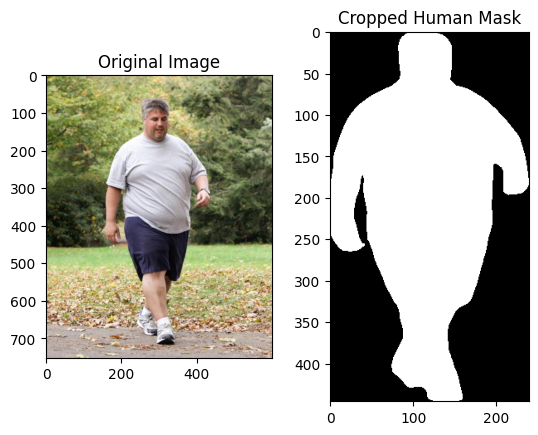

BMI: 15.987740516662598
Underweight


In [34]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

def generate_human_mask(image_path):
    # Load pre-trained DeepLabV3 model from PyTorch
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    # Define transformations
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image using PIL (Python Imaging Library)
    img = Image.open(image_path)

    # Preprocess the image
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        output = model(input_batch)["out"][0]
    output_predictions = output.argmax(0)

    # Create a binary mask for the human class (label 15)
    human_mask = (output_predictions == 15).float().numpy()

    return human_mask

def extract_human_region(image, mask):
    # Find contours or bounding box from the human mask
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print("No human detected.")
        return None, None
    
    # Get the largest contour (assuming it is the human)
    largest_contour = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(largest_contour)
    
    # Crop the human region from the image and the mask
    human_region = image[y:y+h, x:x+w]
    cropped_mask = mask[y:y+h, x:x+w]
    
    return human_region, cropped_mask

# Load the Keras model
model = tf.keras.models.load_model('my_model1.keras')

# Load the image path and generate the human mask
image_path = 'Person.jpg'
human_mask = generate_human_mask(image_path)

# Read the original image
image = cv.imread(image_path)

# Extract the human region from the original image and mask
human_region, human_mask_cropped = extract_human_region(image, human_mask)

# If human detected, proceed with resizing and prediction
if human_region is not None:
    # Resize the human region to the input size expected by the Keras model
    resized_human_region = cv.resize(human_region, (224, 224))
    
    # Normalize and preprocess the image for Keras model
    resized_human_region = resized_human_region / 255.0  # Normalize to [0,1]
    
    # Make predictions using the Keras model
    BMI = model.predict(np.expand_dims(resized_human_region, axis=0))
    
    # Display the original image and the cropped human mask
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(human_mask_cropped, cmap="gray")
    plt.title("Cropped Human Mask")

    plt.show()

    # BMI classification
    print(f"BMI: {BMI[0][0]}")

    if BMI < 18.5:
        print("Underweight")
    elif 18.5 <= BMI < 25:
        print("Normal")
    elif 25 <= BMI < 30:
        print("Overweight")
    else:
        print("Obese")
else:
    print("Human region not found for prediction.")


Using cache found in C:\Users\binoj/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\binoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\binoj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
BMI :  [[14.391708]]
Underweight


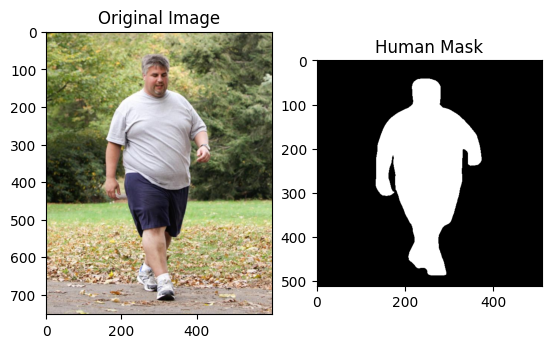

In [36]:
def generate_human_mask(image_path):
    # Load pre-trained DeepLabV3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()

    # Define transformations
    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image using PIL (Python Imaging Library)
    img = Image.open(image_path)

    # Preprocess the image
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    # Make predictions
    with torch.no_grad():
        output = model(input_batch)["out"][0]
    output_predictions = output.argmax(0)

    # Create a mask for the human class (label 15)
    human_mask = (output_predictions == 15).float()

    return human_mask

#preprocessing the user input. This is where masking has to be done.

# Load the Keras model
model = keras.models.load_model('my_model1.keras')

# Load the image path and generate the human mask
image_path = 'person.jpg'
human_mask = generate_human_mask(image_path)

# Convert the PyTorch tensor to a NumPy array and then to a TensorFlow tensor
human_mask_np = human_mask.numpy()  # Convert PyTorch tensor to NumPy array
human_mask_tf = tensorflow.convert_to_tensor(human_mask_np, dtype=tensorflow.float32)  # Convert NumPy array to TensorFlow tensor

# Reshape the tensor if needed (ensure the shape matches the model input shape)
# human_mask_tf = tf.reshape(human_mask_tf, desired_shape)
# Resize the human mask to match the input size expected by the Keras model
resized_human_mask = cv.resize(human_mask.numpy(), (224, 224))  # Resize to (224, 224)

# Expand dimensions to match the model input shape (add batch dimension)
resized_human_mask = np.expand_dims(resized_human_mask, axis=-1)
resized_human_mask = np.repeat(resized_human_mask, 3, axis=-1)  # Repeat for 3 channels (RGB)

# Make predictions using the Keras model
BMI = model.predict(np.expand_dims(resized_human_mask, axis=0))

img = plt.imread(image_path)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(human_mask, cmap="gray")
plt.title("Human Mask")

print(f"BMI : ", BMI)

if BMI < 18.5:
  print("Underweight")
elif 18.5 <= BMI < 25:
  print("Normal")
elif 25 <= BMI < 35:
  print("Overweight")
elif BMI > 35:
  print("Obese")

In [17]:

import os
import shutil

# Source and destination directories
source_directory = 'C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17'
destination_directory = 'image'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Define the image file extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# Walk through all subdirectories in the source directory
for root, dirs, files in os.walk(source_directory):
    for file in files:
        # Check if the file has an image extension
        if any(file.lower().endswith(ext) for ext in image_extensions):
            # Full path of the source file
            file_path = os.path.join(root, file)
            # Full path of the destination file
            dest_path = os.path.join(destination_directory, file)
            # Copy the image to the destination folder
            shutil.copy(file_path, dest_path)
            print(f"Copied: {file_path} to {dest_path}")

print("Image copying completed.")

    

Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\10q8fn\10q8fn_0mII1_230_67_true_72_0.53.jpg to image\10q8fn_0mII1_230_67_true_72_0.53.jpg
Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\10q8fn\10q8fn_BoQMl_180_67_true_72_0.53.jpg to image\10q8fn_BoQMl_180_67_true_72_0.53.jpg
Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\11fex8\11fex8_CZOIF_188_67_false_16_0.75.jpg to image\11fex8_CZOIF_188_67_false_16_0.75.jpg
Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\11fex8\11fex8_VTXKy_230_67_false_16_0.75.jpg to image\11fex8_VTXKy_230_67_false_16_0.75.jpg
Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\11sryq\11sryq_EgJRk_155_69_false_4_1.29.jpg to image\11sryq_EgJRk_155_69_false_4_1.29.jpg
Copied: C:/Users/binoj/Downloads/final_BMI_prediction/bodyface_1to17\11sryq\11sryq_zgJRk_155_69_false_4_1.29.jpg to image\11sryq_zgJRk_155_69_false_4_1.29.jpg
Copied: C:/Users/binoj/Downloads/final_BMI